In [0]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()


# Accepted Loans

In this section we explore and analyze data about accepted loans since 2007 till 2018. 

We will work with data previously cleaned and augmented with census information. Data cleaning and is in a separate notebook under the Data webpage.

In [0]:
df_loan_accepted_cleaned = pd.read_csv('df_loan_accepted_census_cleaned.csv')

A great deal of our EDA has been devoted to understanding the principal features and, even more importantly, which ones can be used for prediction and which ones cannot because their information is updated after the loan is funded. First we examined few relevant features (univariate analysis) and then continued to look at correlations and other visualizations.

## All Loans

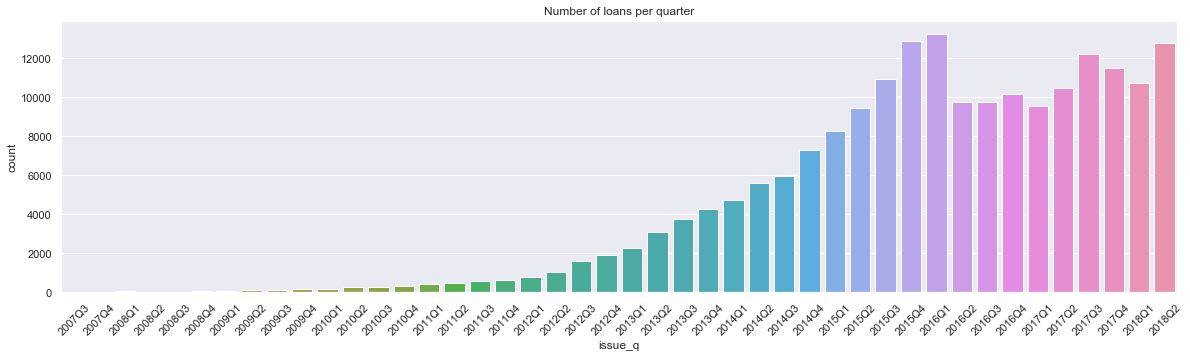

In [0]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.countplot(df_loan_accepted_cleaned.issue_q.sort_values(ascending=True), ax=ax)
plt.title('Number of loans per quarter')
plt.xticks(rotation=45);

As shown below, majority of the loans have been "Fully paid". Many of them are current and few have been charged-off. We can also observed a very few amount of default and late loans.

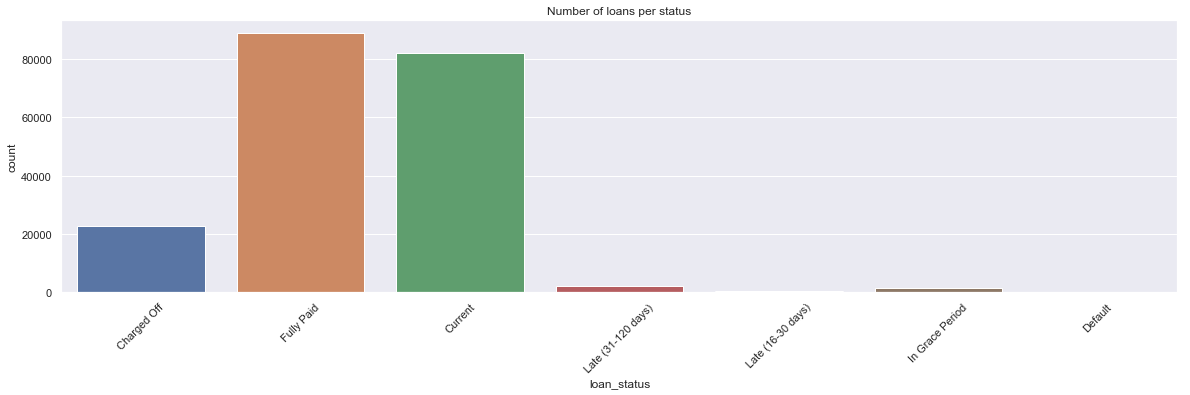

In [0]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.countplot(df_loan_accepted_cleaned.loan_status, ax=ax)
plt.title('Number of loans per status')
plt.xticks(rotation=45);

Feature “Grade” and “subgrade” classify the various loans into high risk and high profit categories. This feature is very useful for to design an investment strategy. Grade A is the one that is funded a lot with minimal percent of default. In the increasing order of default is Grade FG is least funded and has highest loan amount charged off.  Below is a count plot of the number of loans per grade and subgrade.

As depicted below, most loans are 36-months term with interest rate around 12%, which correspond to grades B and C. There are few outliers with very high interest rates, which we will need to carefully consider during modelling. The inbalanced terms and grades should also be considered with care.

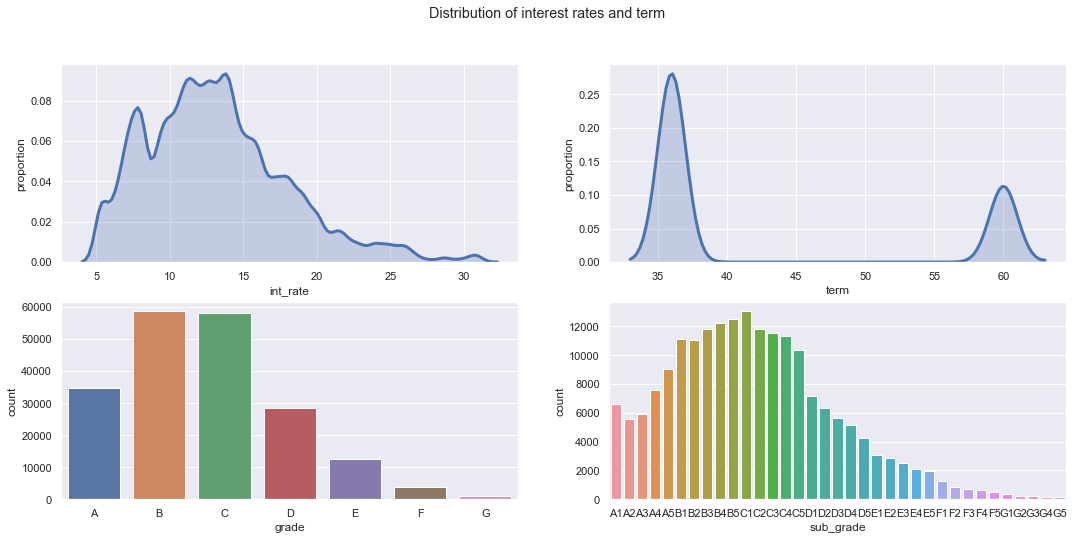

In [0]:
fig, ax = plt.subplots(2,2, figsize=(18,8))
sns.distplot(df_loan_accepted_cleaned.int_rate, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, ax=ax[0][0])
sns.distplot(df_loan_accepted_cleaned.term, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, ax=ax[0][1])
sns.countplot(df_loan_accepted_cleaned.grade, order = ['A','B','C','D','E','F','G'], ax=ax[1][0])
sns.countplot(df_loan_accepted_cleaned.sub_grade, order = np.sort(df_loan_accepted_cleaned.sub_grade.unique()), ax=ax[1][1])
ax[0][0].set_ylabel('proportion')
ax[0][1].set_ylabel('proportion')
plt.suptitle('Distribution of interest rates and term');

As we can see in the plots below, `loan_amnt`, `funded_amnt` and `funded_amnt_inv` have almost the same values distribution. It is safe to keep one of those variables.The listed amount of loan applied by the borrower `loan_amnt` is highly correlated with the total amount committed to that loan `funded_amnt` as well as with the total amount committed by investors `funded_amnt_inv`.

We can closely consider `funded_amnt_inv` because it makes more sense for our project goal which is to advise an investor about the best investment strategy with compliance to fairness.

We also plot the distribution of monthly installments, which follows a similar distribution as loan amounts, as expected.

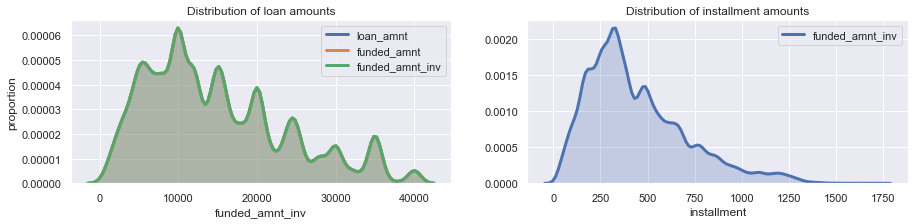

In [0]:
fig, ax = plt.subplots(1,2, figsize=(15,3))
sns.distplot(df_loan_accepted_cleaned.loan_amnt, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label='loan_amnt', ax=ax[0])
sns.distplot(df_loan_accepted_cleaned.funded_amnt, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label='funded_amnt', ax=ax[0])
sns.distplot(df_loan_accepted_cleaned.funded_amnt_inv, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label='funded_amnt_inv', ax=ax[0])
sns.distplot(df_loan_accepted_cleaned.installment, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label='funded_amnt_inv', ax=ax[1])
ax[0].set_ylabel('proportion')
ax[0].set_title('Distribution of loan amounts')
ax[1].set_title('Distribution of installment amounts')
plt.show()

The figure below shows that debt consolidation is the first major purpose and credit card payments is the second major purposes of lending. Most people tend to borrow some money because they previously borrow some. There could be an increase in probability of being "charged off" in this case, which we will investigate in our models.

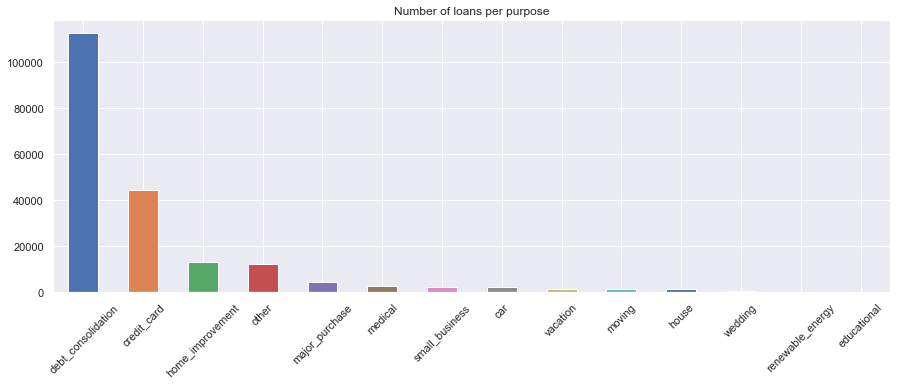

In [0]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
df_loan_accepted_cleaned.purpose.value_counts().plot(kind="bar", ax=ax)
plt.title('Number of loans per purpose')
plt.xticks(rotation=45);

## Paid vs Unpaid Loans

In this section we will have a look at historical loans which were **fully paid** or **charged-off**. Current loans, late or defaulted loans are excluded from this analysis.  

In [0]:
df_loan_for_plot = df_loan_accepted_cleaned.copy()
df_loan_for_plot = df_loan_for_plot[df_loan_for_plot.success.isin([0,1])]

**Funded amount and interest rate**

Below plot we notice that most of these grade have equally paid and unpaid amount when the amount is below a threshold, while for higher valued loan, the grade plays a critical role if the borrower would charge-off.

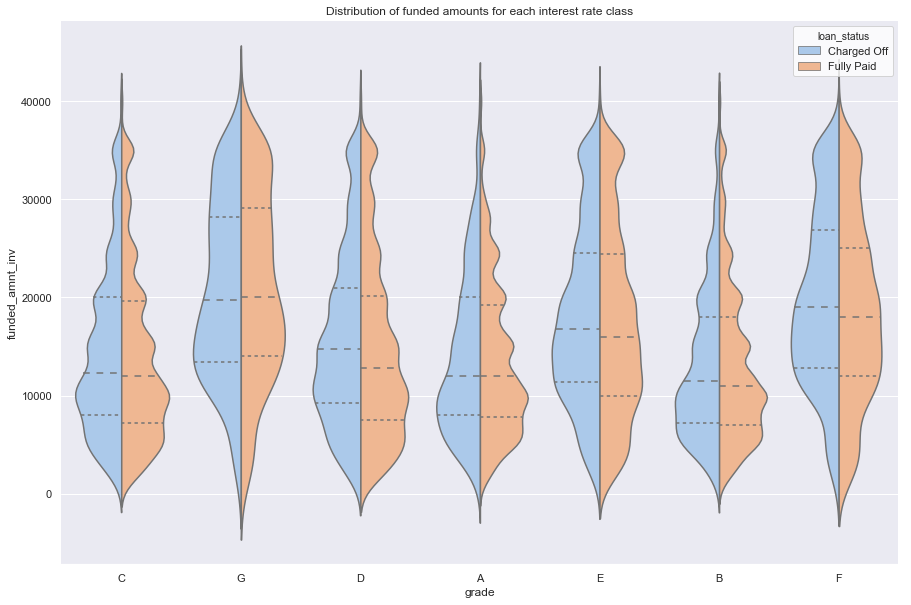

In [0]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="grade", y="funded_amnt_inv", hue="loan_status",
               split=True, inner="quart",
               data=df_loan_for_plot, ax=ax)
sns.despine(left=True)
ax.set_title('Distribution of funded amounts for each interest rate class');

**Charge-off ratio per grade**

It appears that the grade assigned by LendingClub accurately model the risk of charge-off. In the plot below we can see that the percentage of loans which were not fully paid increases linearly with the interest rate. By assigning a higher grade to a risky loan, LendingClub increases the chances for a faster return of investment.

In [0]:
df = df_loan_for_plot[['loan_status', 'grade','zip_code']].groupby(['grade','loan_status']).agg(['count']).reset_index()
df.columns = df.columns.droplevel(level=1)
unpaid = df[df.loan_status == 'Charged Off']['zip_code']
paid = df[df.loan_status == 'Fully Paid']['zip_code']
df_paid_perc = pd.DataFrame({'grade':['A','B','C','D','E','F','G'], 'perc':np.divide(unpaid,np.add(paid,unpaid))*100})

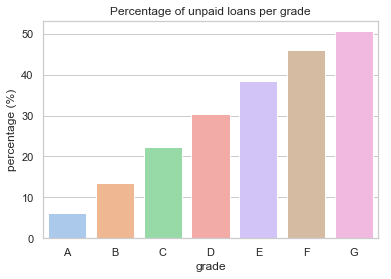

In [0]:
sns.barplot(df_paid_perc.grade, df_paid_perc.perc)
plt.ylabel('percentage (%)')
plt.title('Percentage of unpaid loans per grade');

**Purpose and Term**

The plot below shows that debt consolidation and credit card payments are the major purposes of lending. Most people tend to borrow some money because they previously borrow some.  The purpose is however not related to the likelihood of default in loan payment. 36 months is the most common term.

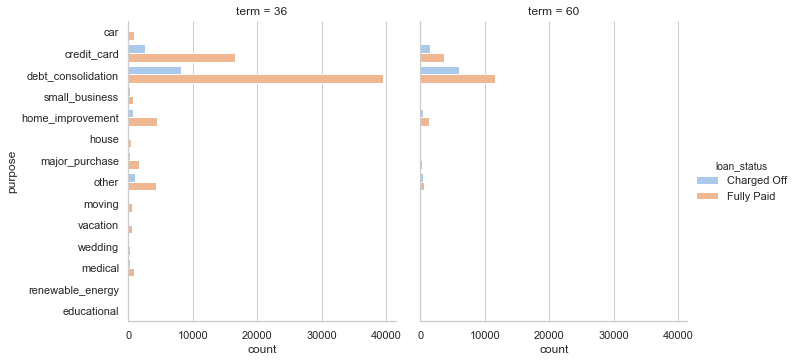

In [0]:
sns.catplot(kind='count', data=df_loan_for_plot, y='purpose', hue='loan_status', col='term');

**Home ownership and employment length**

Below we explore how home ownership and employment length affects the loan outcome for each term (36 or 60 months).

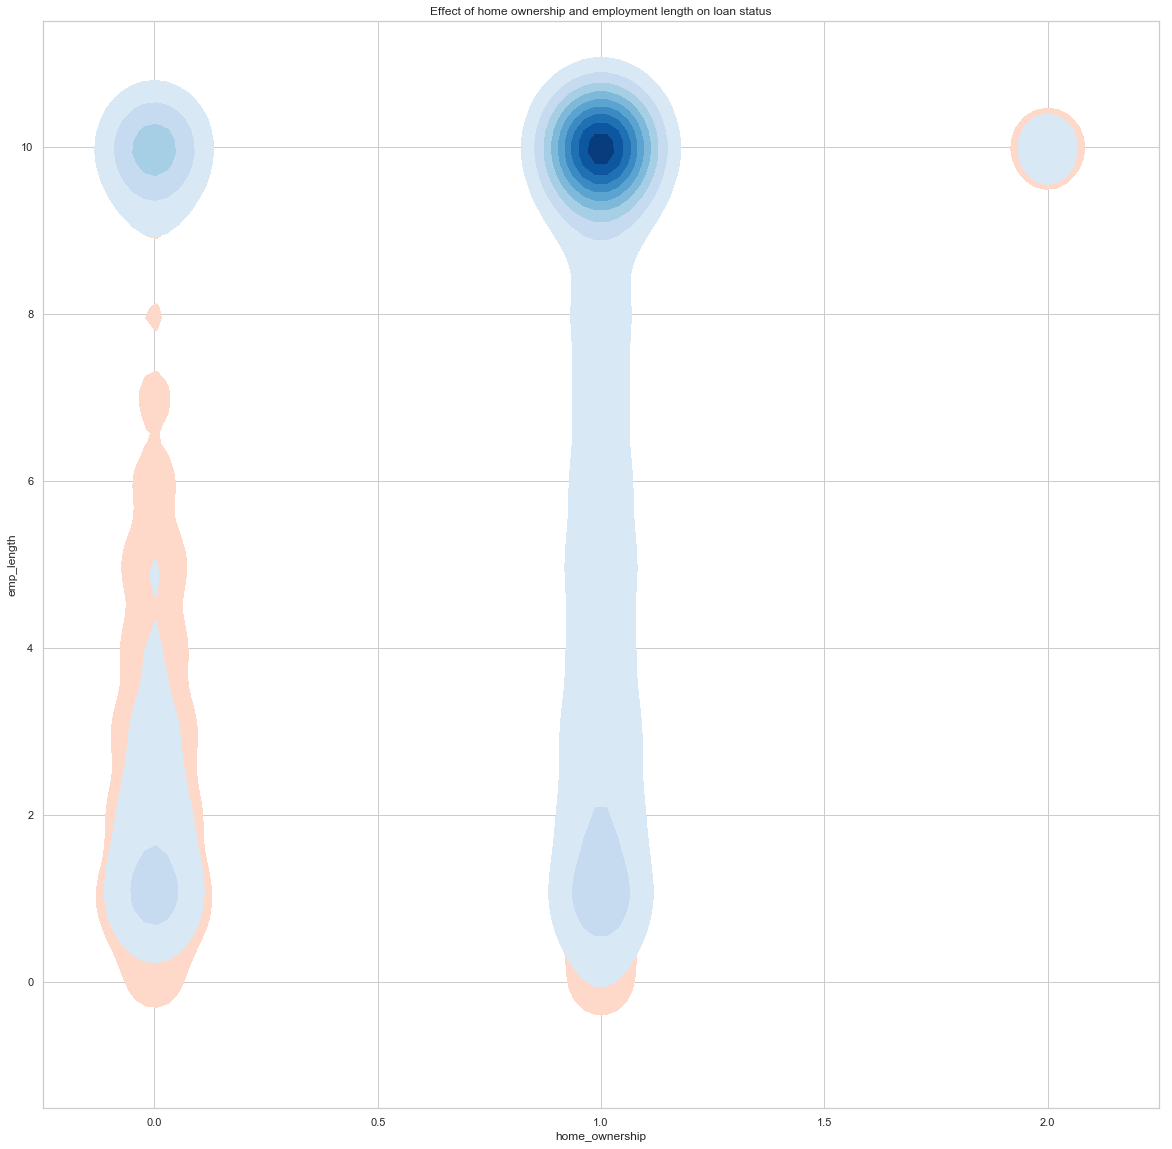

In [0]:
f, ax = plt.subplots(1,1,figsize=(20, 20))
#ax.set_aspect("equal")
term36 = df_loan_for_plot[df_loan_for_plot.term==36].replace({'home_ownership':{'RENT':0,'MORTGAGE':1,'OWN':2,'OTHER':3,'ANY':4,'NONE':5}})
term60 = df_loan_for_plot[df_loan_for_plot.term==60].replace({'home_ownership':{'RENT':0,'MORTGAGE':1,'OWN':2,'OTHER':3,'ANY':4,'NONE':5}})
term36 = term36[term36.home_ownership.isin([0,1,2])]
term60 = term60[term60.home_ownership.isin([0,1,2])]
ax = sns.kdeplot(term36.home_ownership, term36.emp_length,
                 cmap="Reds", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(term60.home_ownership, term60.emp_length,
                 cmap="Blues", shade=True, shade_lowest=False, ax=ax)
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.set_title('Effect of home ownership and employment length on loan status');

**Debt-to-income ratio**

Looking at the plot there is no increasing relationship between the interest rate and the debt-to-income ratio. The charged-off loans are almost equally distributed along the debt-to-income ratio axis and interest rate axis. It could be interesting to investigate whether the likelihood of charged-off is mainly guided by both features.

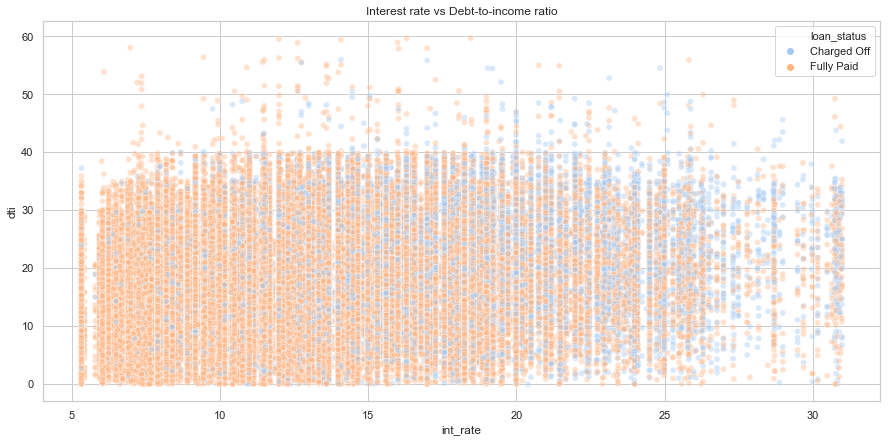

In [0]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.scatterplot(data=df_loan_for_plot[df_loan_for_plot.dti<60], x='int_rate', y='dti', hue='loan_status', alpha=.4, ax=ax)
ax.set_title('Interest rate vs Debt-to-income ratio');

**Revolving bankcards**

The total amount open on revolving bankcards seems not to affect the amount that people will borrow and the likelihood that they will not be able to pay.

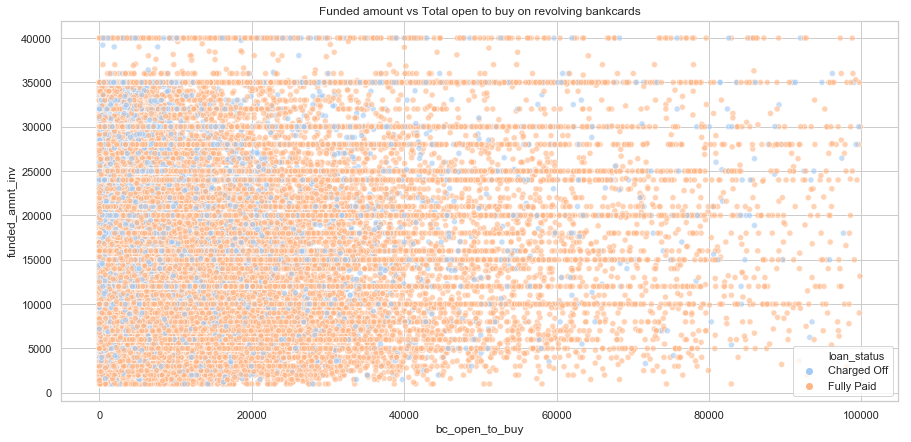

In [0]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.scatterplot(data=df_loan_for_plot[df_loan_for_plot.bc_open_to_buy<100000], x='bc_open_to_buy', y='funded_amnt_inv', hue='loan_status', alpha=.6,ax=ax)
ax.set_title('Funded amount vs Total open to buy on revolving bankcards');

**Credit limit and current balance**

The likelihood of not being debt is probably not dependend on the credit limit of the borrower. People with very high credit limit probably default the same rate as those with low credit limit.

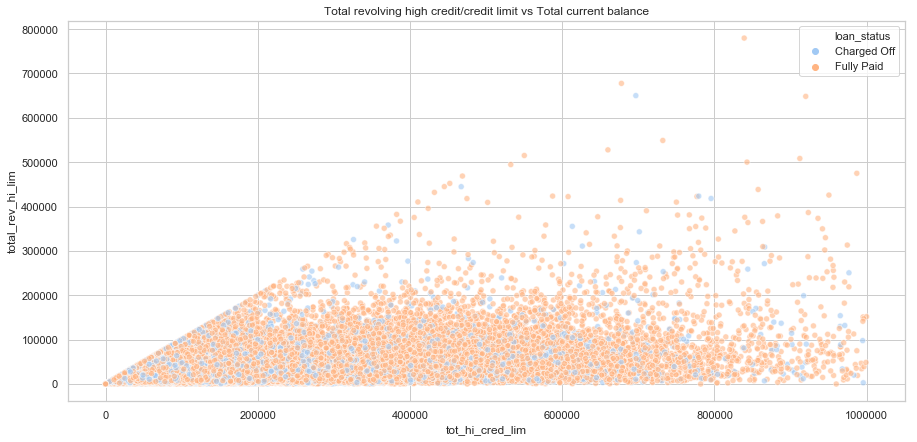

In [0]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.scatterplot(data=df_loan_for_plot[df_loan_for_plot.tot_hi_cred_lim<1000000], x='tot_hi_cred_lim', y='total_rev_hi_lim', hue='loan_status', alpha=.6, ax=ax)
ax.set_title('Total revolving high credit/credit limit vs Total current balance');

**Annual income and loan amount**

LendingClub seems to allow loan amounts at most the half of annual income of the borrower. High loan amount combined with low income look like a precursor of charge-off. Most failed loans are located in that area. Looking at very high income borrower we can still see a lot of failed loans, suggesting that investors should not only look at income.

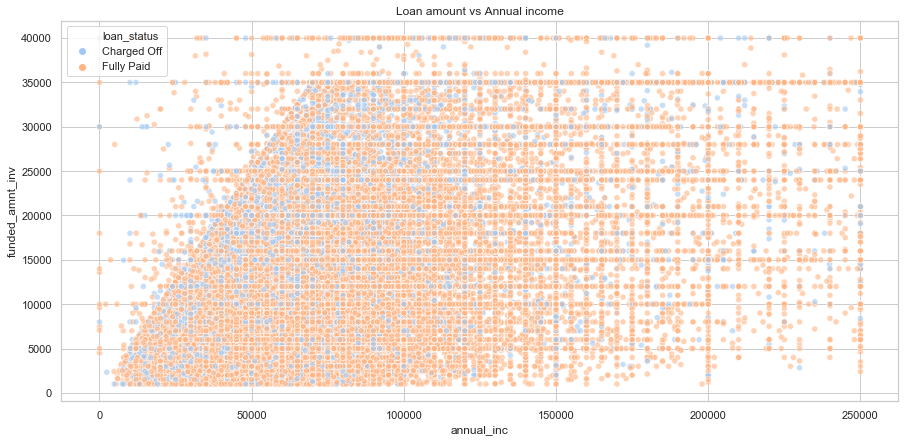

In [0]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.scatterplot(data=df_loan_for_plot[df_loan_for_plot.annual_inc<500000], x='annual_inc', y='funded_amnt_inv', hue='loan_status', alpha=.6, ax=ax)
ax.set_title('Loan amount vs Annual income');

**Credit limit and current balance**

Assuming that the `Total current balance` provided in the dataset was measured at the date when the loan was closed, we can say that the amount of money borrowers do have on their bank accounts does not say much about their ability to pay their loan on time.

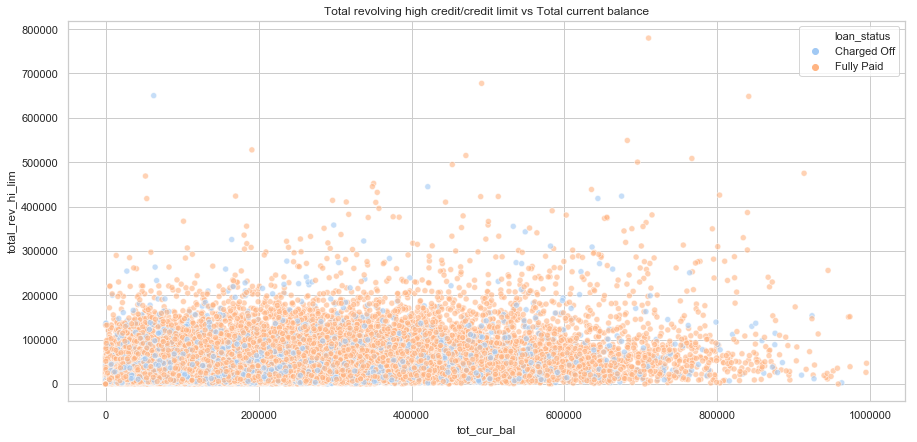

In [0]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.scatterplot(data=df_loan_for_plot[df_loan_for_plot.tot_hi_cred_lim<1000000], x='tot_cur_bal', y='total_rev_hi_lim', hue='loan_status', alpha=.6, ax=ax)
ax.set_title('Total revolving high credit/credit limit vs Total current balance');

## Fairness

We investigate fairness by displaying a stripplot with the distribution of census data. 

Overall it seems the likelihood of failing to fully payback loans is not affected by the race and gender. The distribution of paid and unpaid loans is very similar among groups of borrowers with different race or gender. Surprisingly being English speaker or living in a zone with poverty level below national average is not impacting the ratio of charged-off to fully payment. We think that this is because the data at hand obtained from the Lending Club does not disclose the full zip code for a closer match to census data. 

In [0]:
df = pd.melt(df_loan_for_plot[['loan_status','female_pct','male_pct','White_pct','Black_pct','Native_pct','Asian_pct','Hispanic_pct','poverty_level_below_pct','employment_2016_rate']], "loan_status", var_name="measurement")
df.head()

,loan_status,measurement,value
0,Charged Off,female_pct,0.507231
1,Fully Paid,female_pct,0.507231
2,Charged Off,female_pct,0.507231
3,Fully Paid,female_pct,0.507231
4,Charged Off,female_pct,0.507231


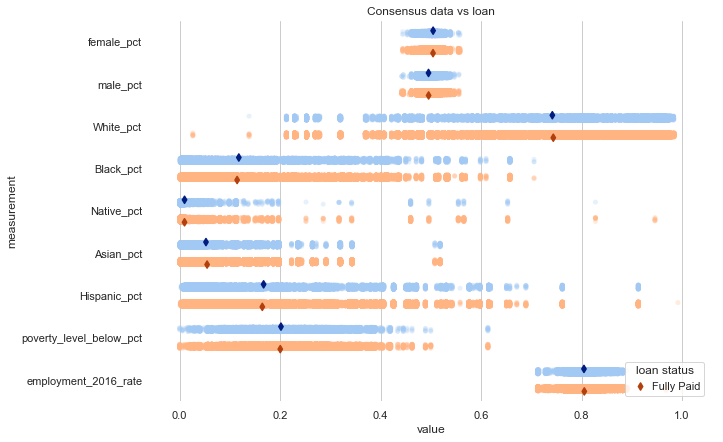

In [0]:
f, ax = plt.subplots(figsize=(10,7))
sns.despine(bottom=True, left=True)
sns.stripplot(x="value", y="measurement", hue="loan_status",
              data=df, dodge=True, jitter=True,
              alpha=.25, zorder=1)
sns.pointplot(x="value", y="measurement", hue="loan_status",
              data=df, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="loan status",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)
ax.set_title('Consensus data vs loan');

We investigate the correlation between census features and loan features.

Looking at bottom left part of the heatmap below, we can say that the correlation between selected loan's features and census features is very low, almost not existent.

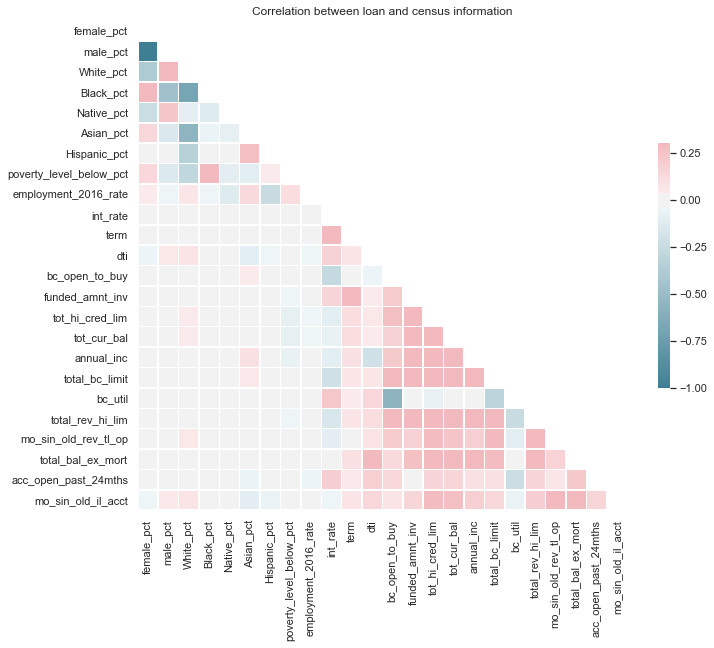

In [0]:
cols1 = ['loan_status','female_pct','male_pct','White_pct','Black_pct','Native_pct','Asian_pct','Hispanic_pct','poverty_level_below_pct','employment_2016_rate']
cols2 = ['int_rate','term','dti','bc_open_to_buy','funded_amnt_inv','tot_hi_cred_lim','tot_cur_bal','annual_inc','total_bc_limit','bc_util','total_rev_hi_lim','mo_sin_old_rev_tl_op','total_bal_ex_mort','acc_open_past_24mths','mo_sin_old_il_acct']
corr = df_loan_for_plot[cols1 + cols2].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation between loan and census information');

# Rejects

In this section we explore and analyze data about rejected loans since 2007 till 2018. 

We will work with data previously cleaned and augmented with census information.

In [0]:
df_loan_rejected_cleaned = pd.read_csv('df_loan_rejected_census_cleaned.csv')

In order to understand the factors which cause a loan request to be rejected, we will merge rejected loan data with accepted loan data and create a response variable reject y/n

In [0]:
df_loan_rejected_cleaned['reject_status'] = 1
df_loan_accepted_cleaned['reject_status'] = 0
df_loan_accepted_cleaned['risk_score'] = -1

In [0]:
df_loan_requests = pd.concat([df_loan_rejected_cleaned, df_loan_accepted_cleaned[df_loan_rejected_cleaned.columns]])

**Rejects per state**

When looking at the rejected loans, i.e. these applications which were not accepted on the Lending Club marketplace because they did not fulfill their policies, we see that there are few states with a large number of rejects such as CA, TX, NY and FL. These states also have the highest count of requests for loan.

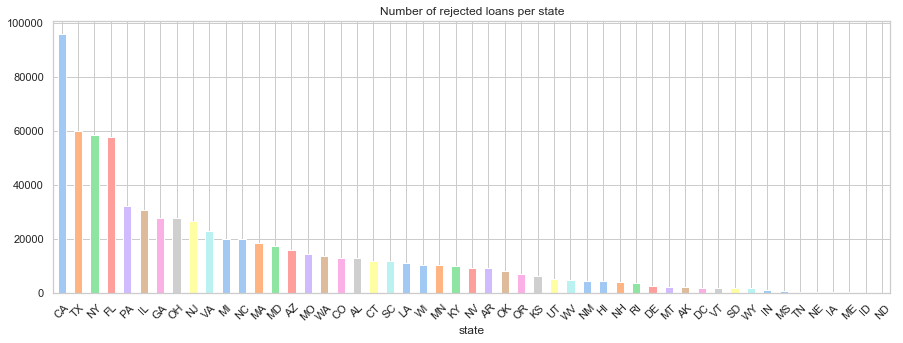

In [0]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
df_loan_rejected_cleaned.addr_state.value_counts().plot(kind="bar", ax=ax)
plt.title('Number of rejected loans per state')
plt.xlabel('state')
plt.xticks(rotation=45);

**Rejects and employment length**

Employment length is definetly a significant factor when it comes to accepting or rejecting a loan at LendngClub, as we can see in the plot below, borrowers with less than a year working experience have almost no chance to get a loan.

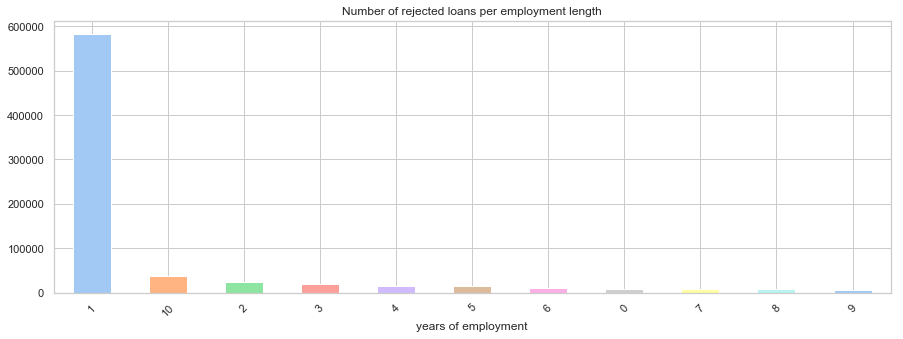

In [0]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
df_loan_rejected_cleaned.emp_length.value_counts().plot(kind="bar", ax=ax)
plt.title('Number of rejected loans per employment length')
plt.xlabel('years of employment')
plt.xticks(rotation=45);

### Reject to accept Ratio

Here we are interested in comparing the count of accepted loans over rejected loans over states.

In [0]:
import geopandas as gpd

Load US states shape file

In [0]:
df_map = gpd.read_file('data/states.shp')

In [0]:
df_map.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...


Aggregate loan data and calculate reject ratio

In [0]:
df_loan_reject_ratio = df_loan_requests[['addr_state','reject_status']].groupby(['addr_state']).agg(['count', 'sum', 'mean'])
df_loan_reject_ratio.columns = df_loan_reject_ratio.columns.droplevel(level=0)
df_loan_reject_ratio = df_loan_reject_ratio[['mean']].rename(columns={'mean':'ratio'})
df_loan_reject_ratio.ratio = (1 - df_loan_reject_ratio.ratio)*100

In [0]:
df_loan_reject_ratio.sort_values(by='ratio', ascending=True).head()

,ratio
addr_state,
IA,0.751880
WV,12.272727
AR,14.194577
AL,15.907137
KY,16.531279


Merge map data with loan reject ratio

In [0]:
df_loan_reject_ratio_map = df_map.set_index('STATE_ABBR').join(df_loan_reject_ratio)
df_loan_reject_ratio_map.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,geometry,ratio
STATE_ABBR,,,,,,
HI,Hawaii,1,15,Pacific,(POLYGON ((-160.0738033454681 22.0041773479577...,19.105691
WA,Washington,2,53,Pacific,(POLYGON ((-122.4020153103835 48.2252163723779...,23.485876
MT,Montana,3,30,Mountain,POLYGON ((-111.4754253002074 44.70216236909688...,20.954598
ME,Maine,4,23,New England,(POLYGON ((-69.77727626137293 44.0741483685119...,79.405941
ND,North Dakota,5,38,West North Central,POLYGON ((-98.73043728833767 45.93827137024809...,88.509317


**Plot reject ratio**

Below we plot the ratio of rejected applications over accepted loans on a map of the US. North Dacota, Tennessee, Idaho, Nevada, Maine states had a considerably high rejects ratio compared to the remaining states. It will be interesting to investigate this discrepancy under the light of a more detailled census data.

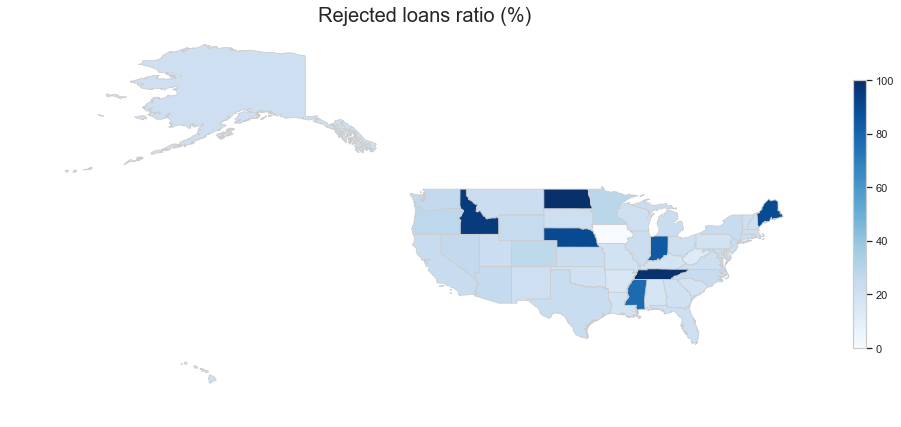

In [0]:
fig, ax = plt.subplots(1, figsize=(15, 15))
df_loan_reject_ratio_map.plot(column='ratio', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Rejected loans ratio (%)', fontdict={'fontsize': '20', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.016, pad=0.04)
fig.savefig("loans_reject_ratio.png", dpi=300)

For those states with high reject ratio, it could be interesting to find out why.

Below we use the census data at hand and compare the top 5 states with high reject ratio with top 5 states with lowest reject ratio.

In [0]:
census_cols = ['Population', 'median_income_2016', 
               'male_pct', 'female_pct', 
               'Black_pct', 'White_pct', 'Native_pct', 'Asian_pct', 'Hispanic_pct', 
               'household_family_pct', 'poverty_level_below_pct', 'Graduate_Degree_pct', 'employment_2016_rate']

In [0]:
top_10_high_reject_ratio = df_loan_reject_ratio.sort_values(by='ratio', ascending=False).reset_index().addr_state.values[0:10]
top_10_high_reject_ratio

array(['ND', 'TN', 'ID', 'NE', 'ME', 'IN', 'MS', 'MN', 'OR', 'CO'],
      dtype=object)

In [0]:
top_10_low_reject_ratio = df_loan_reject_ratio.sort_values(by='ratio', ascending=True).reset_index().addr_state.values[0:10]
top_10_low_reject_ratio

array(['IA', 'WV', 'AR', 'AL', 'KY', 'SC', 'LA', 'PA', 'MO', 'DE'],
      dtype=object)

Mean census values for top 10 states with highest reject ratio.

In [0]:
df_loan_requests[df_loan_requests.addr_state.isin(top_10_high_reject_ratio)][census_cols].mean()

Population                 15317.725680
median_income_2016         60042.766843
male_pct                       0.502030
female_pct                     0.497970
Black_pct                      0.059983
White_pct                      0.852107
Native_pct                     0.009468
Asian_pct                      0.026372
Hispanic_pct                   0.099593
household_family_pct           0.654611
poverty_level_below_pct        0.195452
Graduate_Degree_pct            0.111396
employment_2016_rate           0.805455
dtype: float64

Mean census values for top 10 states with lowest reject ratio.

In [0]:
df_loan_requests[df_loan_requests.addr_state.isin(top_10_low_reject_ratio)][census_cols].mean()

Population                 11984.300967
median_income_2016         50100.615093
male_pct                       0.494185
female_pct                     0.505815
Black_pct                      0.164912
White_pct                      0.783837
Native_pct                     0.003888
Asian_pct                      0.015700
Hispanic_pct                   0.042260
household_family_pct           0.659689
poverty_level_below_pct        0.220816
Graduate_Degree_pct            0.086540
employment_2016_rate           0.809399
dtype: float64

The mean values above do not help us understanding why those states are so differently handled by LendingClub. Some external resources such as unemployment rate, downgrade of the economy, associated with those states are required.

In [0]:
df_loan_requests.issue_q.unique()

array(['2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
       '2008Q4', '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1',
       '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3',
       '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2014Q2',
       '2013Q3', '2018Q1', '2015Q1', '2016Q2', '2016Q1', '2018Q2',
       '2015Q3', '2017Q4', '2017Q2', '2016Q4', '2017Q3', '2015Q4',
       '2013Q4', '2015Q2', '2016Q3', '2017Q1', '2013Q2', '2014Q3',
       '2014Q1', '2013Q1', '2014Q4'], dtype=object)

In [0]:
df_high = df_loan_requests[df_loan_requests.addr_state.isin(top_10_high_reject_ratio)][['employment_2016_rate','addr_state','issue_q']]
df_low = df_loan_requests[df_loan_requests.addr_state.isin(top_10_low_reject_ratio)][['employment_2016_rate','addr_state','issue_q']]
df_high['ratio'] = 'high reject ratio'
df_low['ratio'] = 'low reject ratio'
df = pd.concat([df_high, df_low])
df.issue_q = df.issue_q.str.slice(0, 4)
df = df[df.issue_q=='2016']

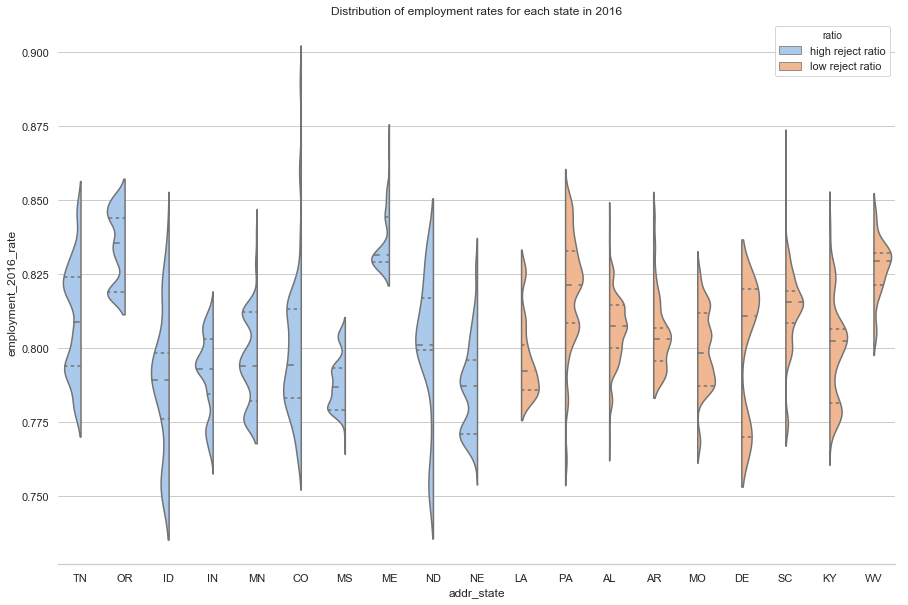

In [0]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="addr_state", y="employment_2016_rate", hue='ratio',
               split=True, inner="quart",
               data=df, ax=ax)
sns.despine(left=True)
ax.set_title('Distribution of employment rates for each state in 2016');

The distribution of employment rate (2016) in states where people applied for loans does not clearly differentiate between the states with highest reject ratio and those with lowest reject ratio. We might need to research some other factors in the macro-economy of those states at the time when loans were requested.